In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from olympus.datasets import Dataset
from olympus.emulators import Emulator

from olympus.models import BayesNeuralNet

In [9]:
res = pickle.load(open('best_scores.pkl', 'rb'))

In [10]:
dataset_names = [
    'oer_plate_4098', 'oer_plate_3851', 'oer_plate_3860', 'oer_plate_3496',
    'p3ht', 'agnp', 
    'thin_film', 'crossed_barrel', 'autoam', 
    'suzuki_i', 'suzuki_ii', 'suzuki_iii', 'suzuki_iv',
]






dataset_params = { 
        'oer_plate_4098': {'out_act': 'sigmoid', 'feature_transform': 'identity', 'target_transform': 'normalize'},
        'oer_plate_3851': {'out_act': 'sigmoid', 'feature_transform': 'identity', 'target_transform': 'normalize'},
        'oer_plate_3860': {'out_act': 'sigmoid', 'feature_transform': 'identity', 'target_transform': 'normalize'},
        'oer_plate_3496': {'out_act': 'sigmoid', 'feature_transform': 'identity', 'target_transform': 'normalize'},
        #
        'p3ht': {'out_act': 'relu', 'feature_transform': 'standardize', 'target_transform': 'normalize'},
        'thin_film': {'out_act': 'relu', 'feature_transform': 'identity', 'target_transform': 'normalize'},
        'crossed_barrel': {'out_act': 'relu', 'feature_transform': 'standardize', 'target_transform': 'normalize'},
        'autoam': {'out_act': 'sigmoid', 'feature_transform': 'standardize', 'target_transform': 'normalize'},
        'agnp': {'out_act': 'sigmoid', 'feature_transform': 'standardize', 'target_transform': 'normalize'},
        #
        'suzuki_i': {'out_act': 'sigmoid', 'feature_transform': 'standardize', 'target_transform': 'normalize'},
        'suzuki_ii': {'out_act': 'sigmoid', 'feature_transform': 'standardize', 'target_transform': 'normalize'},
        'suzuki_iii': {'out_act': 'sigmoid', 'feature_transform': 'standardize', 'target_transform': 'normalize'},
        'suzuki_iv': {'out_act': 'sigmoid', 'feature_transform': 'standardize', 'target_transform': 'normalize'},
}

dataset_best_ixs = {
    'oer_plate_4098': 2,   #  train_r2': 0.7734599256992053, 'test_r2': 0.7945569505695091
    'oer_plate_3851': 32,  #  train_r2': 0.7550674210800261, 'test_r2': 0.7802528067931549,
    'oer_plate_3860': 5,   #  'train_r2': 0.9686675003169638, 'test_r2': 0.9133091715158632,
    'oer_plate_3496': 31,  # 'train_r2': 0.8266571602618243, 'test_r2': 0.8259005341918386
    'p3ht': 22,            # 'train_r2': 0.6975751443410381, 'test_r2': 0.7793890439647247
    'agnp': 37,            #  'train_r2': 0.9919709204743246, 'test_r2': 0.9674480835430533
    'thin_film': 4,        #  'train_r2': 0.908612564150724, 'test_r2': 0.8894377000285831
    'crossed_barrel': 36,  # 'train_r2': 0.9163651357831107, 'test_r2': 0.8733565068897925
    'autoam': 27,          #  'train_r2': 0.9840880858308613, 'test_r2': 0.9748034395964649
    'suzuki_i': 17,        # 'train_r2': 0.9801417703097964, 'test_r2': 0.9639942659087248
    'suzuki_ii': 40 ,      # 'train_r2': 0.9374492642454046, 'test_r2': 0.9384759277089572,
    'suzuki_iii': 41,      # 'train_r2': 0.9920817495563271, 'test_r2': 0.993137817447446
    'suzuki_iv': 11,       # 'train_r2': 0.9750797192551808, 'test_r2': 0.9576396387718573,
}

In [11]:
def get_best_scores(res, dataset):
    scores = res[dataset]['scores']
    test_r2 = []
    sum_r2 = []
    for ix, score in enumerate(scores):
        test_r2.append(score['test_r2'])
        sum_r2.append(score['test_r2']+score['train_r2'])
    best_ix_test = np.argmax(test_r2)
    best_scores_test = scores[best_ix_test]
    best_ix_sum = np.argmax(sum_r2)
    best_scores_sum = scores[best_ix_sum]
    return best_ix_test, best_scores_test, best_ix_sum, best_scores_sum


def get_hyperparams(res, dataset_name, best_ix):
    return res[dataset_name]['params'][best_ix]

In [12]:
# for dataset in dataset_names:
#     print('DATASET : ', dataset)
#     best_ix_test, best_scores_test, best_ix_sum, best_scores_sum = get_best_scores(res, dataset)
#     print('best_ix_test : ', best_ix_test)
#     print('best_scores_test : ', best_scores_test)
#     print('best_ix_sum : ', best_ix_sum)
#     print('best_scores_sum : ', best_scores_sum)
#     print('\n\n')


In [13]:
# train the networks and make predictions on train/test set

for dataset_name in dataset_names:
    d = Dataset(kind=dataset_name)
    hyperparams = get_hyperparams(res, dataset_name, dataset_best_ixs[dataset_name])
    test_indices = res[dataset_name]['all_test_indices'][dataset_best_ixs[dataset_name]]
    
    model  = BayesNeuralNet(**hyperparams, out_act=dataset_params[dataset_name]['out_act'])
    emulator = Emulator(
        dataset=dataset_name, 
        model=model,
        feature_transform=dataset_params[dataset_name]['feature_transform'],
        target_transform=dataset_params[dataset_name]['target_transform']
    )
    emulator.dataset.create_train_validate_test_splits(test_indices=test_indices)
    
    print('DATASET : ', dataset_name)
    print(emulator)
    
    scores = emulator.train()
    
    train_params = d.train_set_features.to_numpy()
    train_values = d.train_set_targets.to_numpy()
    test_params = d.test_set_features.to_numpy()
    test_values = d.test_set_targets.to_numpy()
    
    train_preds = emulator.run(train_params, num_samples=50)
    test_preds  = emulator.run(test_params, num_samples=50)
    
    
    dataset_params[dataset_name]['train_preds'] = train_preds
    dataset_params[dataset_name]['test_preds'] = test_preds
    dataset_params[dataset_name]['scores'] = scores
    dataset_params[dataset_name]['emulator'] = emulator
    
    emulator.save(f'emulator_{dataset_name}_BayesNeuralNet')
    
    
    

DATASET :  oer_plate_4098
<Emulator (Dataset(kind=oer_plate_4098), model=
--> batch_size:    50
--> es_patience:   100
--> hidden_act:    leaky_relu
--> hidden_depth:  3
--> hidden_nodes:  28
--> kind:          BayesNeuralNet
--> learning_rate: 0.0010682491425291207
--> max_epochs:    100000
--> out_act:       sigmoid
--> pred_int:      100
--> reg:           0.003225897970756163
--> scope:         model)>
[INFO] >>> Training model on 80% of the dataset, testing on 20%...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.975          0.241         -1.797          0.238 *
[INFO]             100          0.192          0.154          0.239          0.124 *
[INFO]             200          0.578          0.111          0.570          0.093 *
[INFO]             300          0.603          0.108          0.624          0.087 *
[INFO]             400          0.630          0.104          0.625          0.087 *
[INFO]             500          0.677          0.097          0.643          0.085 *
[INFO]             600          0.673          0.098          0.681          0.080 *
[INFO]             700          0.683          0.096          0.697          0.078 *
[INFO]             800          0.705          0.093          0.680    

[INFO]            8500          0.800          0.077          0.737          0.073
[INFO]            8600          0.790          0.078          0.744          0.072
[INFO]            8700          0.802          0.076          0.736          0.073
[INFO]            8800          0.798          0.077          0.735          0.073
[INFO]            8900          0.801          0.076          0.732          0.074
[INFO]            9000          0.796          0.077          0.742          0.072
[INFO]            9100          0.792          0.078          0.729          0.074
[INFO]            9200          0.793          0.078          0.736          0.073
[INFO]            9300          0.790          0.079          0.732          0.074
[INFO]            9400          0.807          0.075          0.720          0.075
[INFO]            9500          0.804          0.076          0.737          0.073
[INFO]            9600          0.800          0.076          0.716          0.076
[INF

/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.147          0.165         -0.265          0.158 *
[INFO]             100          0.542          0.104          0.640          0.084 *
[INFO]             200          0.523          0.106          0.668          0.081 *
[INFO]             300          0.546          0.104          0.661          0.082
[INFO]             400          0.559          0.102          0.685          0.079 *
[INFO]             500          0.552          0.103          0.667          0.081
[INFO]             600          0.584          0.099          0.679          0.080
[INFO]             700          0.600          0.097          0.717          0.075 *
[INFO]             800          0.631          0.093          0.747          

[INFO]            8400          0.695          0.085          0.823          0.059
[INFO]            8500          0.682          0.087          0.829          0.058
[INFO]            8600          0.706          0.083          0.823          0.059
[INFO]            8700          0.704          0.084          0.826          0.059
[INFO]            8800          0.711          0.083          0.818          0.060
[INFO]            8900          0.698          0.084          0.817          0.060
[INFO]            9000          0.709          0.083          0.820          0.060
[INFO]            9100          0.710          0.083          0.824          0.059
[INFO]            9200          0.694          0.085          0.825          0.059
[INFO]            9300          0.706          0.083          0.821          0.060
[INFO]            9400          0.684          0.086          0.835          0.057 *
[INFO]            9500          0.694          0.085          0.835          0.057
[I

[INFO]           17300          0.691          0.085          0.839          0.056
[INFO]           17400          0.703          0.084          0.837          0.057
[INFO]           17500          0.712          0.082          0.821          0.060
[INFO]           17600          0.716          0.082          0.841          0.056
[INFO]           17700          0.712          0.082          0.840          0.056
[INFO]           17800          0.704          0.084          0.835          0.057
[INFO]           17900          0.706          0.083          0.834          0.057
[INFO]           18000          0.711          0.083          0.830          0.058
[INFO]           18100          0.705          0.083          0.837          0.057
[INFO]           18200          0.699          0.084          0.833          0.058
[INFO]           18300          0.698          0.084          0.837          0.057
[INFO]           18400          0.700          0.084          0.846          0.055
[INF

[INFO]           26100          0.711          0.083          0.826          0.059
[INFO]           26200          0.693          0.085          0.848          0.055
[INFO]           26300          0.711          0.083          0.841          0.056
[INFO]           26400          0.722          0.081          0.830          0.058
[INFO]           26500          0.697          0.085          0.833          0.057
[INFO]           26600          0.713          0.082          0.830          0.058
[INFO]           26700          0.711          0.083          0.833          0.057
[INFO]           26800          0.706          0.083          0.827          0.058
[INFO]           26900          0.704          0.084          0.831          0.058
[INFO]           27000          0.701          0.084          0.834          0.057
[INFO]           27100          0.704          0.084          0.849          0.055
[INFO]           27200          0.702          0.084          0.834          0.057
[INF

/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.827          0.255         -1.518          0.247 *
[INFO]             100          0.841          0.075          0.742          0.079 *
[INFO]             200          0.901          0.059          0.795          0.070 *
[INFO]             300          0.893          0.062          0.815          0.067 *
[INFO]             400          0.861          0.070          0.787          0.072
[INFO]             500          0.903          0.059          0.830          0.064 *
[INFO]             600          0.862          0.070          0.787          0.072
[INFO]             700          0.886          0.064          0.784          0.072
[INFO]             800          0.863          0.070          0.755          

[INFO]            8400          0.936          0.048          0.869          0.056
[INFO]            8500          0.939          0.047          0.874          0.055
[INFO]            8600          0.951          0.042          0.858          0.059
[INFO]            8700          0.936          0.048          0.845          0.061
[INFO]            8800          0.927          0.051          0.814          0.067
[INFO]            8900          0.925          0.052          0.878          0.054
[INFO]            9000          0.951          0.042          0.850          0.060
[INFO]            9100          0.942          0.045          0.852          0.060
[INFO]            9200          0.944          0.045          0.852          0.060
[INFO]            9300          0.929          0.050          0.785          0.072
[INFO]            9400          0.942          0.045          0.881          0.054
[INFO]            9500          0.946          0.044          0.882          0.053
[INF

[INFO]           17200          0.944          0.045          0.801          0.069
[INFO]           17300          0.944          0.045          0.863          0.058
[INFO]           17400          0.942          0.045          0.873          0.055
[INFO]           17500          0.942          0.045          0.846          0.061
[INFO]           17600          0.947          0.043          0.869          0.056
[INFO]           17700          0.936          0.048          0.839          0.062
[INFO]           17800          0.947          0.044          0.834          0.063
[INFO]           17900          0.942          0.045          0.817          0.066
[INFO]           18000          0.950          0.042          0.836          0.063
[INFO]           18100          0.927          0.051          0.826          0.065
[INFO]           18200          0.945          0.044          0.888          0.052
[INFO]           18300          0.944          0.045          0.857          0.059
[INF

[INFO]           26100          0.952          0.041          0.851          0.060
[INFO]           26200          0.944          0.045          0.827          0.065
[INFO]           26300          0.955          0.040          0.834          0.063
[INFO]           26400          0.954          0.041          0.809          0.068
[INFO]           26500          0.954          0.040          0.870          0.056
[INFO]           26600          0.942          0.046          0.796          0.070
[INFO]           26700          0.955          0.040          0.849          0.060
[INFO]           26800          0.949          0.042          0.853          0.060
[INFO]           26900          0.957          0.039          0.862          0.058
[INFO]           27000          0.956          0.039          0.838          0.062
[INFO]           27100          0.947          0.043          0.854          0.059
[INFO]           27200          0.955          0.040          0.832          0.064
[INF

/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -7.155          0.321         -3.526          0.317 *
[INFO]             100          0.590          0.072          0.348          0.120 *
[INFO]             200          0.719          0.060          0.528          0.102 *
[INFO]             300          0.783          0.052          0.540          0.101 *
[INFO]             400          0.783          0.052          0.576          0.097 *
[INFO]             500          0.721          0.059          0.547          0.100
[INFO]             600          0.770          0.054          0.589          0.095 *
[INFO]             700          0.701          0.061          0.610          0.093 *
[INFO]             800          0.782          0.052          0.598      

[INFO]            8400          0.856          0.043          0.803          0.066
[INFO]            8500          0.845          0.044          0.809          0.065
[INFO]            8600          0.852          0.043          0.809          0.065
[INFO]            8700          0.845          0.044          0.816          0.064
[INFO]            8800          0.842          0.045          0.822          0.063
[INFO]            8900          0.825          0.047          0.835          0.060 *
[INFO]            9000          0.823          0.047          0.838          0.060 *
[INFO]            9100          0.840          0.045          0.844          0.059 *
[INFO]            9200          0.848          0.044          0.837          0.060
[INFO]            9300          0.840          0.045          0.838          0.060
[INFO]            9400          0.842          0.045          0.834          0.061
[INFO]            9500          0.837          0.045          0.836          0.06

[INFO]           17200          0.851          0.043          0.842          0.059
[INFO]           17300          0.876          0.040          0.823          0.063
[INFO]           17400          0.857          0.042          0.838          0.060
[INFO]           17500          0.835          0.046          0.849          0.058
[INFO]           17600          0.825          0.047          0.863          0.055
[INFO]           17700          0.837          0.045          0.864          0.055
[INFO]           17800          0.844          0.044          0.842          0.059
[INFO]           17900          0.828          0.047          0.841          0.059
[INFO]           18000          0.842          0.045          0.843          0.059
[INFO]           18100          0.838          0.045          0.856          0.056
[INFO]           18200          0.853          0.043          0.853          0.057
[INFO]           18300          0.837          0.045          0.856          0.057
[INF

[INFO]           26100          0.864          0.041          0.866          0.054
[INFO]           26200          0.864          0.041          0.861          0.056
[INFO]           26300          0.870          0.041          0.845          0.058
[INFO]           26400          0.844          0.044          0.883          0.051 *
[INFO]           26500          0.862          0.042          0.862          0.055
[INFO]           26600          0.870          0.040          0.854          0.057
[INFO]           26700          0.868          0.041          0.865          0.055
[INFO]           26800          0.850          0.043          0.867          0.054
[INFO]           26900          0.860          0.042          0.859          0.056
[INFO]           27000          0.857          0.043          0.860          0.056
[INFO]           27100          0.852          0.043          0.874          0.053
[INFO]           27200          0.865          0.041          0.847          0.058
[I

[INFO]           34900          0.841          0.045          0.877          0.052
[INFO]           35000          0.843          0.045          0.874          0.053
[INFO]           35100          0.855          0.043          0.859          0.056
[INFO]           35200          0.850          0.043          0.868          0.054
[INFO]           35300          0.844          0.044          0.869          0.054
[INFO]           35400          0.854          0.043          0.862          0.055
[INFO]           35500          0.861          0.042          0.850          0.058
[INFO]           35600          0.864          0.041          0.860          0.056
[INFO]           35700          0.836          0.045          0.872          0.053
[INFO]           35800          0.818          0.048          0.874          0.053
[INFO]           35900          0.855          0.043          0.867          0.054
[INFO]           36000          0.846          0.044          0.864          0.055
[INF

DATASET :  p3ht
<Emulator (Dataset(kind=p3ht), model=
--> batch_size:    30
--> es_patience:   100
--> hidden_act:    leaky_relu
--> hidden_depth:  4
--> hidden_nodes:  52
--> kind:          BayesNeuralNet
--> learning_rate: 0.002098500170906052
--> max_epochs:    100000
--> out_act:       relu
--> pred_int:      100
--> reg:           0.3293274107991943
--> scope:         model)>
[INFO] >>> Training model on 80% of the dataset, testing on 20%...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -1.438          0.456         -0.618          0.323 *
[INFO]             100         -1.441          0.456         -0.618          0.323
[INFO]             200         -1.441          0.456         -0.618          0.323
[INFO]             300          0.614          0.181          0.514          0.177 *
[INFO]             400          0.642          0.175          0.597          0.161 *
[INFO]             500          0.614          0.181          0.659          0.148 *
[INFO]             600          0.608          0.183          0.636          0.153
[INFO]             700          0.660          0.170          0.644          0.152
[INFO]             800          0.635          0.177          0.614          0.

[INFO]            8600          0.539          0.198          0.523          0.175
[INFO]            8700          0.528          0.201          0.635          0.153
[INFO]            8800          0.507          0.205          0.513          0.177
[INFO]            8900          0.459          0.215          0.627          0.155
[INFO]            9000          0.569          0.192          0.428          0.192
[INFO]            9100          0.528          0.201          0.605          0.160
[INFO]            9200          0.539          0.198          0.577          0.165
[INFO]            9300          0.582          0.189          0.552          0.170
[INFO]            9400          0.535          0.199          0.527          0.175
[INFO]            9500          0.493          0.208          0.566          0.167
[INFO]            9600          0.524          0.202          0.621          0.156
[INFO]            9700          0.584          0.188          0.610          0.159
[INF

[INFO]           17400          0.651          0.173          0.744          0.128
[INFO]           17500          0.627          0.179          0.762          0.124
[INFO]           17600          0.623          0.179          0.794          0.115
[INFO]           17700          0.626          0.179          0.833          0.104 *
[INFO]           17800          0.612          0.182          0.793          0.116
[INFO]           17900          0.649          0.173          0.764          0.123
[INFO]           18000          0.664          0.169          0.807          0.112
[INFO]           18100          0.605          0.184          0.791          0.116
[INFO]           18200          0.610          0.182          0.752          0.127
[INFO]           18300          0.619          0.180          0.764          0.123
[INFO]           18400          0.637          0.176          0.786          0.118
[INFO]           18500          0.640          0.175          0.776          0.120
[I

[INFO]           26200          0.633          0.177          0.762          0.124
[INFO]           26300          0.627          0.179          0.736          0.130
[INFO]           26400          0.642          0.175          0.779          0.119
[INFO]           26500          0.609          0.183          0.799          0.114
[INFO]           26600          0.614          0.182          0.800          0.114
[INFO]           26700          0.643          0.175          0.796          0.115
[INFO]           26800          0.626          0.179          0.788          0.117
[INFO]           26900          0.652          0.172          0.772          0.121
[INFO]           27000          0.618          0.180          0.831          0.104
[INFO]           27100          0.624          0.179          0.731          0.132
[INFO]           27200          0.638          0.176          0.782          0.118
[INFO]           27300          0.630          0.178          0.764          0.123
[INF

[ERROR] Lower bound of 9.999518096000001 provided for parameter `q_pva` is higher than minimum found in the data!
[ERROR] Lower bound of 0.498851653 provided for parameter `q_seed` is higher than minimum found in the data!
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0          0.008          0.248          0.023          0.319 *
[INFO]             100          0.923          0.069          0.901          0.102 *
[INFO]             200          0.943          0.060          0.914          0.095 *
[INFO]             300          0.955          0.053          0.926          0.088 *
[INFO]             400          0.927          0.068          0.901          0.102
[INFO]             500          0.937          0.063          0.922          0.090
[INFO]             600          0.940          0.061          0.913          0.095
[INFO]             700          0.935          0.063          0.912          0.096
[INFO]             800          0.908          0.076          0.899          0.

[INFO]            8400          0.994          0.019          0.962          0.063
[INFO]            8500          0.994          0.020          0.963          0.063
[INFO]            8600          0.995          0.018          0.964          0.061
[INFO]            8700          0.995          0.018          0.961          0.064
[INFO]            8800          0.994          0.019          0.963          0.062
[INFO]            8900          0.993          0.020          0.961          0.064
[INFO]            9000          0.995          0.018          0.963          0.062
[INFO]            9100          0.994          0.020          0.960          0.064
[INFO]            9200          0.994          0.019          0.964          0.061
[INFO]            9300          0.995          0.018          0.962          0.063
[INFO]            9400          0.994          0.020          0.963          0.062
[INFO]            9500          0.994          0.019          0.960          0.064
[INF

[WARNING] Not all parameters are within bounds
[WARNING] Not all parameters are within bounds
[WARNING] Not all parameters are within bounds
[WARNING] Not all parameters are within bounds


DATASET :  thin_film
<Emulator (Dataset(kind=thin_film), model=
--> batch_size:    40
--> es_patience:   100
--> hidden_act:    leaky_relu
--> hidden_depth:  3
--> hidden_nodes:  60
--> kind:          BayesNeuralNet
--> learning_rate: 0.004620079334234118
--> max_epochs:    100000
--> out_act:       relu
--> pred_int:      100
--> reg:           0.13256355036498163
--> scope:         model)>
[INFO] >>> Training model on 80% of the dataset, testing on 20%...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.903          0.250         -0.221          0.310 *
[INFO]             100          0.527          0.125          0.726          0.147 *
[INFO]             200          0.408          0.139          0.641          0.168
[INFO]             300          0.565          0.119          0.665          0.162
[INFO]             400          0.681          0.102          0.657          0.164
[INFO]             500          0.689          0.101          0.696          0.155
[INFO]             600          0.595          0.115          0.690          0.156
[INFO]             700          0.728          0.094          0.734          0.145 *
[INFO]             800          0.687          0.101          0.715          0.15

[INFO]            8400          0.882          0.062          0.791          0.128
[INFO]            8500          0.902          0.057          0.806          0.123
[INFO]            8600          0.910          0.054          0.804          0.124
[INFO]            8700          0.904          0.056          0.778          0.132
[INFO]            8800          0.899          0.058          0.801          0.125
[INFO]            8900          0.882          0.062          0.802          0.125
[INFO]            9000          0.910          0.054          0.852          0.108 *
[INFO]            9100          0.922          0.051          0.841          0.112
[INFO]            9200          0.899          0.058          0.806          0.124
[INFO]            9300          0.898          0.058          0.811          0.122
[INFO]            9400          0.903          0.056          0.810          0.122
[INFO]            9500          0.897          0.058          0.820          0.119
[I

[INFO]           17200          0.921          0.051          0.763          0.136
[INFO]           17300          0.925          0.050          0.809          0.123
[INFO]           17400          0.884          0.062          0.768          0.135
[INFO]           17500          0.916          0.052          0.770          0.134
[INFO]           17600          0.914          0.053          0.799          0.126
[INFO]           17700          0.899          0.058          0.757          0.138
[INFO]           17800          0.879          0.063          0.765          0.136
[INFO]           17900          0.919          0.052          0.797          0.126
[INFO]           18000          0.924          0.050          0.770          0.135
[INFO]           18100          0.927          0.049          0.756          0.138
[INFO]           18200          0.908          0.055          0.763          0.136
[INFO]           18300          0.919          0.052          0.773          0.134
[INF

/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.628          0.318         -0.805          0.402 *
[INFO]             100          0.620          0.154          0.507          0.210 *
[INFO]             200          0.574          0.162          0.429          0.226
[INFO]             300          0.491          0.178          0.484          0.215
[INFO]             400          0.591          0.159          0.586          0.193 *
[INFO]             500          0.613          0.155          0.553          0.200
[INFO]             600          0.597          0.158          0.562          0.198
[INFO]             700          0.683          0.140          0.660          0.174 *
[INFO]             800          0.671          0.143          0.588          0.

[INFO]            8400          0.903          0.078          0.724          0.157
[INFO]            8500          0.913          0.074          0.743          0.152
[INFO]            8600          0.898          0.080          0.728          0.156
[INFO]            8700          0.908          0.075          0.734          0.154
[INFO]            8800          0.900          0.079          0.745          0.151
[INFO]            8900          0.890          0.083          0.720          0.158
[INFO]            9000          0.910          0.075          0.789          0.137
[INFO]            9100          0.886          0.084          0.757          0.147
[INFO]            9200          0.907          0.076          0.721          0.158
[INFO]            9300          0.905          0.077          0.719          0.159
[INFO]            9400          0.892          0.082          0.758          0.147
[INFO]            9500          0.878          0.087          0.719          0.159
[INF

[INFO]           17200          0.919          0.071          0.756          0.148
[INFO]           17300          0.917          0.072          0.769          0.144
[INFO]           17400          0.911          0.074          0.759          0.147
[INFO]           17500          0.929          0.066          0.756          0.148
[INFO]           17600          0.909          0.075          0.773          0.143
[INFO]           17700          0.923          0.069          0.772          0.143
[INFO]           17800          0.920          0.070          0.734          0.154
[INFO]           17900          0.920          0.070          0.754          0.148
[INFO]           18000          0.909          0.075          0.746          0.151
[INFO]           18100          0.907          0.076          0.750          0.150
[INFO]           18200          0.922          0.070          0.764          0.145
[INFO]           18300          0.918          0.071          0.729          0.156
[INF

/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.646          0.330          0.041          0.338 *
[INFO]             100          0.843          0.102          0.896          0.112 *
[INFO]             200          0.790          0.118          0.901          0.109 *
[INFO]             300          0.774          0.122          0.932          0.090 *
[INFO]             400          0.847          0.101          0.898          0.110
[INFO]             500          0.858          0.097          0.912          0.102
[INFO]             600          0.868          0.094          0.933          0.089 *
[INFO]             700          0.888          0.086          0.978          0.051 *
[INFO]             800          0.923          0.071          0.942        

[INFO]            8500          0.983          0.033          0.977          0.053
[INFO]            8600          0.986          0.030          0.973          0.056
[INFO]            8700          0.989          0.027          0.970          0.060
[INFO]            8800          0.979          0.037          0.971          0.059
[INFO]            8900          0.985          0.031          0.975          0.054
[INFO]            9000          0.980          0.036          0.976          0.054
[INFO]            9100          0.977          0.039          0.968          0.061
[INFO]            9200          0.979          0.038          0.969          0.061
[INFO]            9300          0.983          0.034          0.968          0.062
[INFO]            9400          0.984          0.033          0.969          0.061
[INFO]            9500          0.975          0.040          0.975          0.054
[INFO]            9600          0.979          0.037          0.974          0.055
[INF

/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.011          0.304         -0.069          0.336 *
[INFO]             100          0.892          0.099          0.952          0.074 *
[INFO]             200          0.901          0.095          0.932          0.087
[INFO]             300          0.864          0.112          0.941          0.081
[INFO]             400          0.857          0.115          0.871          0.121
[INFO]             500          0.846          0.119          0.815          0.144
[INFO]             600          0.857          0.115          0.828          0.138
[INFO]             700          0.868          0.110          0.845          0.130
[INFO]             800          0.863          0.113          0.821          0.141


[INFO]            8500          0.984          0.039          0.959          0.067
[INFO]            8600          0.984          0.039          0.952          0.073
[INFO]            8700          0.984          0.039          0.959          0.067
[INFO]            8800          0.984          0.038          0.958          0.068
[INFO]            8900          0.982          0.040          0.955          0.071
[INFO]            9000          0.982          0.041          0.955          0.070
[INFO]            9100          0.982          0.041          0.955          0.070
[INFO]            9200          0.982          0.041          0.956          0.069
[INFO]            9300          0.986          0.037          0.959          0.067
[INFO]            9400          0.984          0.039          0.957          0.070
[INFO]            9500          0.985          0.037          0.950          0.075
[INFO]            9600          0.985          0.038          0.954          0.071
[INF

[INFO]           17300          0.985          0.037          0.959          0.067
[INFO]           17400          0.983          0.039          0.956          0.070
[INFO]           17500          0.987          0.034          0.957          0.068
[INFO]           17600          0.986          0.036          0.962          0.064
[INFO]           17700          0.986          0.037          0.957          0.068
[INFO]           17800          0.983          0.040          0.958          0.068
[INFO]           17900          0.984          0.038          0.957          0.069
[INFO]           18000          0.985          0.038          0.951          0.073
[INFO]           18100          0.984          0.038          0.961          0.065
[INFO]           18200          0.984          0.038          0.956          0.069
[INFO]           18300          0.984          0.039          0.961          0.065
[INFO]           18400          0.984          0.039          0.958          0.068
[INF

/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.030          0.348         -1.180          0.408 *
[INFO]             100          0.851          0.133          0.888          0.093 *
[INFO]             200          0.873          0.123          0.855          0.105
[INFO]             300          0.885          0.117          0.864          0.102
[INFO]             400          0.843          0.136          0.874          0.098
[INFO]             500          0.908          0.104          0.913          0.081 *
[INFO]             600          0.882          0.118          0.923          0.076 *
[INFO]             700          0.893          0.113          0.864          0.101
[INFO]             800          0.896          0.111          0.957          0.

[INFO]            8400          0.971          0.059          0.988          0.029
[INFO]            8500          0.977          0.053          0.982          0.036
[INFO]            8600          0.969          0.061          0.980          0.039
[INFO]            8700          0.954          0.074          0.987          0.031
[INFO]            8800          0.976          0.054          0.992          0.025
[INFO]            8900          0.964          0.065          0.988          0.030
[INFO]            9000          0.959          0.070          0.987          0.031
[INFO]            9100          0.967          0.062          0.984          0.035
[INFO]            9200          0.966          0.063          0.981          0.038
[INFO]            9300          0.968          0.062          0.982          0.037
[INFO]            9400          0.961          0.068          0.986          0.032
[INFO]            9500          0.963          0.066          0.985          0.033
[INF

[INFO]           17300          0.975          0.054          0.982          0.037
[INFO]           17400          0.975          0.054          0.985          0.033
[INFO]           17500          0.975          0.055          0.980          0.039
[INFO]           17600          0.975          0.055          0.980          0.038
[INFO]           17700          0.974          0.055          0.982          0.037
[INFO]           17800          0.976          0.053          0.977          0.042
[INFO]           17900          0.974          0.055          0.976          0.043
[INFO]           18000          0.971          0.059          0.979          0.040
[INFO]           18100          0.968          0.061          0.984          0.035
[INFO]           18200          0.970          0.059          0.978          0.041
[INFO]           18300          0.951          0.076          0.982          0.037
[INFO]           18400          0.975          0.055          0.985          0.034
[INF

/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.034          0.377         -0.261          0.381 *
[INFO]             100          0.794          0.163          0.661          0.193 *
[INFO]             200          0.926          0.095          0.928          0.086 *
[INFO]             300          0.960          0.071          0.961          0.064 *
[INFO]             400          0.969          0.064          0.964          0.062 *
[INFO]             500          0.972          0.062          0.962          0.066
[INFO]             600          0.977          0.056          0.966          0.062 *
[INFO]             700          0.972          0.061          0.968          0.063
[INFO]             800          0.974          0.060          0.973        

[INFO]            8400          0.982          0.049          0.983          0.045
[INFO]            8500          0.982          0.048          0.981          0.049
[INFO]            8600          0.985          0.047          0.974          0.054
[INFO]            8700          0.984          0.046          0.986          0.041
[INFO]            8800          0.985          0.046          0.975          0.053
[INFO]            8900          0.984          0.047          0.981          0.047
[INFO]            9000          0.985          0.044          0.985          0.040
[INFO]            9100          0.983          0.049          0.976          0.054
[INFO]            9200          0.980          0.052          0.984          0.044
[INFO]            9300          0.984          0.045          0.980          0.049
[INFO]            9400          0.984          0.047          0.979          0.048
[INFO]            9500          0.986          0.044          0.984          0.044
[INF

[INFO]           17100          0.983          0.048          0.992          0.032
[INFO]           17200          0.986          0.044          0.989          0.038
[INFO]           17300          0.983          0.047          0.993          0.031 *
[INFO]           17400          0.985          0.046          0.989          0.038
[INFO]           17500          0.983          0.047          0.988          0.039
[INFO]           17600          0.986          0.043          0.989          0.037
[INFO]           17700          0.983          0.048          0.988          0.039
[INFO]           17800          0.985          0.045          0.988          0.038
[INFO]           17900          0.986          0.044          0.991          0.035
[INFO]           18000          0.984          0.047          0.991          0.033
[INFO]           18100          0.984          0.047          0.988          0.039
[INFO]           18200          0.986          0.043          0.991          0.033
[I

[INFO]           25800          0.986          0.044          0.993          0.029
[INFO]           25900          0.986          0.042          0.992          0.031
[INFO]           26000          0.983          0.048          0.993          0.029
[INFO]           26100          0.986          0.043          0.993          0.031
[INFO]           26200          0.986          0.044          0.993          0.030
[INFO]           26300          0.986          0.043          0.992          0.031
[INFO]           26400          0.985          0.045          0.993          0.030
[INFO]           26500          0.986          0.044          0.993          0.030
[INFO]           26600          0.986          0.044          0.993          0.031
[INFO]           26700          0.985          0.045          0.993          0.029
[INFO]           26800          0.984          0.046          0.993          0.029
[INFO]           26900          0.986          0.043          0.993          0.029
[INF

[INFO]           34600          0.986          0.043          0.993          0.029
[INFO]           34700          0.987          0.042          0.993          0.030
[INFO]           34800          0.987          0.042          0.993          0.030
[INFO]           34900          0.986          0.044          0.993          0.029
[INFO]           35000          0.988          0.041          0.993          0.031
[INFO]           35100          0.988          0.040          0.993          0.030
[INFO]           35200          0.986          0.044          0.993          0.030
[INFO]           35300          0.987          0.042          0.993          0.030
[INFO]           35400          0.987          0.043          0.992          0.031
[INFO]           35500          0.987          0.041          0.994          0.028
[INFO]           35600          0.987          0.042          0.993          0.031
[INFO]           35700          0.988          0.041          0.993          0.030
[INF

/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO]     =======================================================================
[INFO]           Epoch       Train R2     Train RMSD        Test R2      Test RMSD
[INFO]     =======================================================================
[INFO]               0         -0.604          0.315         -0.190          0.335 *
[INFO]             100          0.878          0.083          0.779          0.152 *
[INFO]             200          0.921          0.068          0.844          0.124 *
[INFO]             300          0.872          0.088          0.842          0.126
[INFO]             400          0.859          0.090          0.865          0.113 *
[INFO]             500          0.781          0.112          0.907          0.095 *
[INFO]             600          0.830          0.100          0.877          0.111
[INFO]             700          0.845          0.095          0.894          0.104
[INFO]             800          0.849          0.094          0.897          

[INFO]            8400          0.965          0.048          0.951          0.071
[INFO]            8500          0.968          0.045          0.954          0.069
[INFO]            8600          0.962          0.049          0.956          0.067
[INFO]            8700          0.965          0.048          0.959          0.064 *
[INFO]            8800          0.960          0.050          0.960          0.065
[INFO]            8900          0.959          0.051          0.954          0.068
[INFO]            9000          0.962          0.049          0.952          0.070
[INFO]            9100          0.955          0.053          0.954          0.069
[INFO]            9200          0.961          0.050          0.960          0.063 *
[INFO]            9300          0.964          0.048          0.953          0.068
[INFO]            9400          0.959          0.051          0.959          0.064
[INFO]            9500          0.963          0.049          0.956          0.067


[INFO]           17300          0.969          0.045          0.954          0.068
[INFO]           17400          0.961          0.050          0.956          0.067
[INFO]           17500          0.967          0.046          0.952          0.069
[INFO]           17600          0.968          0.045          0.957          0.066
[INFO]           17700          0.969          0.045          0.944          0.074
[INFO]           17800          0.964          0.049          0.949          0.071
[INFO]           17900          0.967          0.046          0.953          0.069
[INFO]           18000          0.972          0.043          0.942          0.076
[INFO]           18100          0.955          0.054          0.957          0.066
[INFO]           18200          0.963          0.049          0.940          0.076
[INFO]           18300          0.960          0.050          0.951          0.070
[INFO]           18400          0.970          0.044          0.950          0.070
[INF

In [14]:
_olympus_reference_colors = [
    "#08294C",
    "#75BBE1",
    "#D4E9F4",
    "#F2F2F2",
    "#F7A4D4",
    "#F75BB6",
    "#EB0789",
]

dataset_targets = {
    'oer_plate_4098': 'overpotential [V]',  
    'oer_plate_3851': 'overpotential [V]',  
    'oer_plate_3860': 'overpotential [V]',  
    'oer_plate_3496': 'overpotential [V]',  
    'p3ht': 'conductivity',           
    'agnp': 'spectrum score',           
    'thin_film': 'instability index',       
    'crossed_barrel': 'mechanical toughness',  
    'autoam': 'shape score',           
    'suzuki_i': ['yield [%]', '[prod/cat]'],        
    'suzuki_ii': ['yield [%]', '[prod/cat]'],       
    'suzuki_iii': ['yield [%]', '[prod/cat]'],       
    'suzuki_iv': ['yield [%]', '[prod/cat]'],       
}

In [15]:
from sklearn.metrics import r2_score

[INFO] Loading emulator using a BayesNeuralNet model for the dataset oer_plate_4098...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset oer_plate_3851...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset oer_plate_3860...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset oer_plate_3496...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset p3ht...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset agnp...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
[WARNING] Not all parameters are within bounds
[WARNING] Not all parameters are within bounds


[INFO] Loading emulator using a BayesNeuralNet model for the dataset thin_film...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset crossed_barrel...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset autoam...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


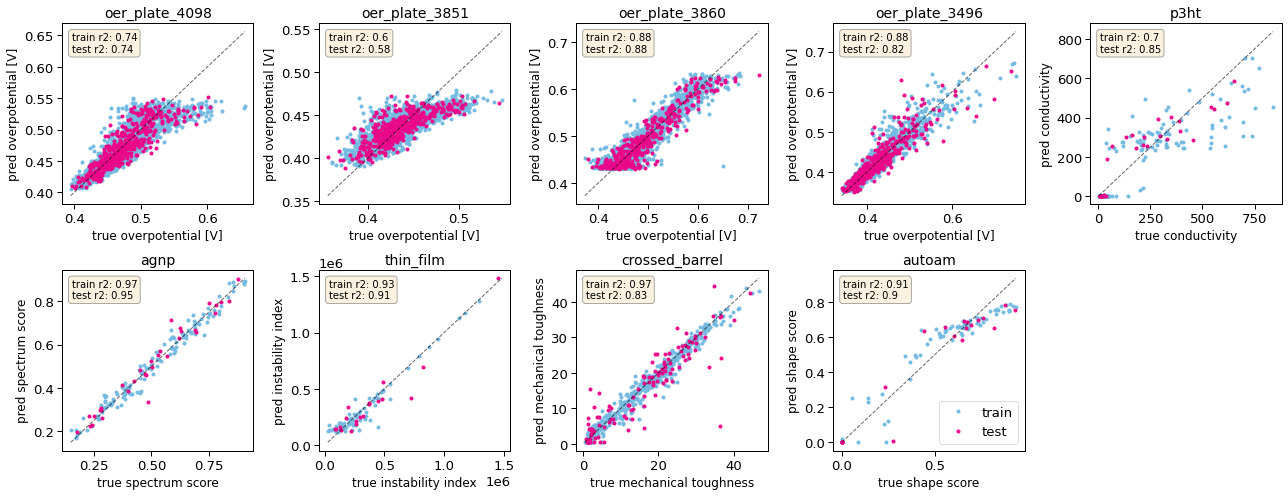

In [16]:
# make plots for single objective datasets

fig, axes = plt.subplots(2, 5, figsize=(18, 7))
axes = axes.flatten()

for ix, dataset_name in enumerate(dataset_names):
    if 'suzuki_' not in dataset_name:
        
        em = Emulator(dataset=dataset_name, model='BayesNeuralNet')
#         test_indices = res[dataset_name]['all_test_indices'][dataset_best_ixs[dataset_name]]
#         d.create_train_validate_test_splits(test_indices=test_indices)
    
        train_params = em.dataset.train_set_features.to_numpy()
        train_values = em.dataset.train_set_targets.to_numpy()
        test_params  = em.dataset.test_set_features.to_numpy()
        test_values  = em.dataset.test_set_targets.to_numpy()

        train_preds = em.run(train_params, num_samples=50)
        test_preds  = em.run(test_params, num_samples=50)
        
        
        train_r2 = round(r2_score(train_values, train_preds), 2)
        test_r2  = round(r2_score(test_values, test_preds), 2)
        
        # training data 
        axes[ix].plot(
            train_values.ravel(),
            train_preds.ravel(),
            c="#75BBE1",
            ls='',
            marker='o',
            markersize=3,
            label='train',
        )
        
        # training data 
        axes[ix].plot(
            test_values.ravel(),
            test_preds.ravel(),
            c="#EB0789",
            ls='',
            marker='o',
            markersize=3,
            label='test',
        )  
        
        max_ = np.amax(np.concatenate(
            (train_preds.ravel(), train_values.ravel(), test_preds.ravel(), test_values.ravel())
        ))
        min_ = np.amin(np.concatenate(
            (train_preds.ravel(), train_values.ravel(), test_preds.ravel(), test_values.ravel())
        ))
        axes[ix].plot([min_, max_], [min_, max_], ls='--', c='k', lw=1, alpha=0.6)
        
        axes[ix].set_xlabel(f'true {dataset_targets[dataset_name]}', fontsize=12)
        axes[ix].set_ylabel(f'pred {dataset_targets[dataset_name]}', fontsize=12)
        axes[ix].set_title(dataset_name, fontsize=14)
        
        str_ = f'train r2: {train_r2}\ntest r2: {test_r2}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
        axes[ix].text(
            0.05, 
            0.95, 
            str_, 
            transform=axes[ix].transAxes, 
            fontsize=10,
            verticalalignment='top', 
            bbox=props,
        )
        
        
    else:
        pass

axes[-2].legend(loc='lower right')
axes[-1].axis('off')
        
plt.tight_layout()
plt.savefig('emualtors_single_obj_pairity.png', dpi=400)

[INFO] Loading emulator using a BayesNeuralNet model for the dataset suzuki_i...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset suzuki_ii...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset suzuki_iii...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


[INFO] Loading emulator using a BayesNeuralNet model for the dataset suzuki_iv...


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


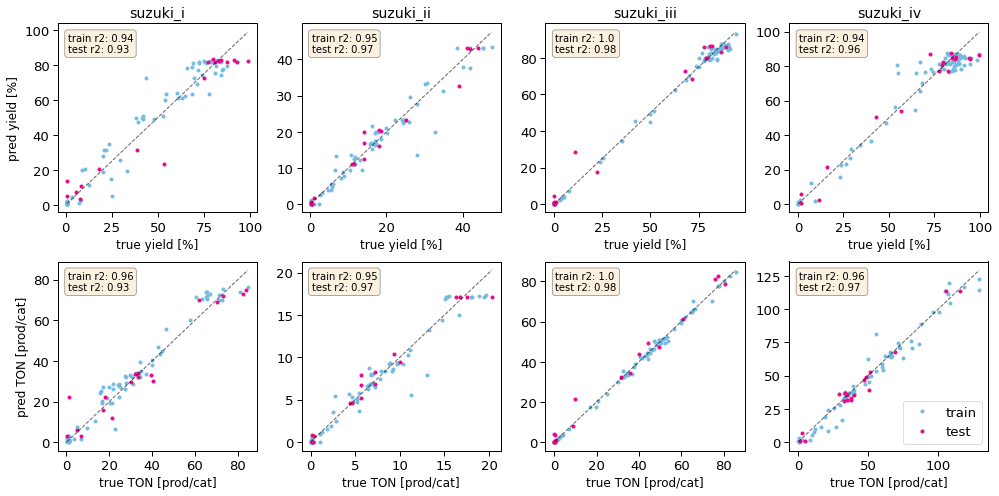

In [17]:
# make plots for multiple objective datasets

fig, axes = plt.subplots(2, 4, figsize=(14, 7))

suzuki_datasets = [d for d in dataset_names if 'suzuki_' in d]
for ix, dataset_name in enumerate(suzuki_datasets):
    if 'suzuki_' in dataset_name:
        
        em = Emulator(dataset=dataset_name, model='BayesNeuralNet')
#         test_indices = res[dataset_name]['all_test_indices'][dataset_best_ixs[dataset_name]]
#         d.create_train_validate_test_splits(test_indices=test_indices)
    
        train_params = em.dataset.train_set_features.to_numpy()
        train_values = em.dataset.train_set_targets.to_numpy()
        test_params  = em.dataset.test_set_features.to_numpy()
        test_values  = em.dataset.test_set_targets.to_numpy()

        train_preds = em.run(train_params, num_samples=50)
        test_preds  = em.run(test_params, num_samples=50)
        
        train_r2_yield = round(r2_score(train_values[:,0], train_preds[:,0]), 2)
        train_r2_ton = round(r2_score(train_values[:,1], train_preds[:,1]), 2)
        test_r2_yield = round(r2_score(test_values[:,0], test_preds[:,0]), 2)
        test_r2_ton = round(r2_score(test_values[:,1], test_preds[:,1]), 2)
        
        # training data yield
        axes[0, ix].plot(
            train_values[:,0].ravel(),
            train_preds[:,0].ravel(),
            c="#75BBE1",
            ls='',
            marker='o',
            markersize=3,
            label='train',
        )
        
        # testing data yield
        axes[0, ix].plot(
            test_values[:,0].ravel(),
            test_preds[:,0].ravel(),
            c="#EB0789",
            ls='',
            marker='o',
            markersize=3,
            label='test',
        )  
        
         # training data yield
        axes[1, ix].plot(
            train_values[:,1].ravel(),
            train_preds[:,1].ravel(),
            c="#75BBE1",
            ls='',
            marker='o',
            markersize=3,
            label='train',
        )
        
        # testing data yield
        axes[1, ix].plot(
            test_values[:,1].ravel(),
            test_preds[:,1].ravel(),
            c="#EB0789",
            ls='',
            marker='o',
            markersize=3,
            label='test',
        )  
        
        max_yield = np.amax(np.concatenate(
            (train_preds[:,0].ravel(), train_values[:,0].ravel(), test_preds[:,0].ravel(), test_values[:,0].ravel())
        ))
        min_yield = np.amin(np.concatenate(
            (train_preds[:,0].ravel(), train_values[:,0].ravel(), test_preds[:,0].ravel(), test_values[:,0].ravel())
        ))
        
        max_ton = np.amax(np.concatenate(
            (train_preds[:,1].ravel(), train_values[:,1].ravel(), test_preds[:,1].ravel(), test_values[:,1].ravel())
        ))
        min_ton = np.amin(np.concatenate(
            (train_preds[:,1].ravel(), train_values[:,1].ravel(), test_preds[:,1].ravel(), test_values[:,1].ravel())
        ))
        
        
        axes[0, ix].plot([min_yield, max_yield], [min_yield, max_yield], ls='--', c='k', lw=1, alpha=0.6)
        axes[1, ix].plot([min_ton, max_ton], [min_ton, max_ton], ls='--', c='k', lw=1, alpha=0.6)
        
        axes[0, ix].set_xlabel(f'true yield [%]', fontsize=12)
        axes[1, ix].set_xlabel(f'true TON [prod/cat]', fontsize=12)
        axes[0, ix].set_title(dataset_name, fontsize=14)
        
        str_ = f'train r2: {train_r2_yield}\ntest r2: {test_r2_yield}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
        axes[0,ix].text(
            0.05, 
            0.95, 
            str_, 
            transform=axes[0, ix].transAxes, 
            fontsize=10,
            verticalalignment='top', 
            bbox=props,
        )
        
        str_ = f'train r2: {train_r2_ton}\ntest r2: {test_r2_ton}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
        axes[1,ix].text(
            0.05, 
            0.95, 
            str_, 
            transform=axes[1, ix].transAxes, 
            fontsize=10,
            verticalalignment='top', 
            bbox=props,
        )
        
        
    else:
        pass
    
axes[0, 0].set_ylabel(f'pred yield [%]', fontsize=12)
axes[1, 0].set_ylabel(f'pred TON [prod/cat]', fontsize=12)

axes[-1, -1].legend(loc='lower right')

plt.tight_layout()
plt.savefig('suzuki_emulators.png', dpi=400)

In [ ]:
dataset_params['p3ht']['scores']

In [11]:
emulator = Emulator(dataset='alkox', model='BayesNeuralNet')
print(emulator)

[INFO] Loading emulator using a BayesNeuralNet model for the dataset alkox...
<Emulator (Dataset(kind=alkox), model=
--> batch_size:    20
--> es_patience:   100
--> hidden_act:    leaky_relu
--> hidden_depth:  3
--> hidden_nodes:  48
--> kind:          BayesNeuralNet
--> learning_rate: 0.001
--> max_epochs:    10000
--> out_act:       linear
--> pred_int:      100
--> reg:           0.001
--> scope:         model)>


In [12]:
d = Dataset(kind='p3ht')
ix0 = d.test_indices

In [13]:
d = Dataset(kind='p3ht')
ix1 = d.test_indices

In [14]:
ix0

array([127, 141,  13, 100,  11, 133,  34, 160,  12,  77, 108,   7,  27,
        58,  37, 174,  65,  75, 137, 164,  28,  63, 111,  72, 138,  66,
       159, 102,  79,  57, 147,  18, 114, 146, 177,  96])

In [15]:
ix1

array([ 95, 129, 115,  74,  14,  18, 130,  44,   3,   6,  97, 108, 162,
         2,  85,  36,  34, 110,   1,  38, 154,  80, 139, 148,  58,  99,
        63, 155, 106, 128, 121,  66, 141,  90,   9, 158])

In [16]:
emulator.dataset.test_indices

array([129, 151,  87, 107, 116,  12,  34, 191,   6,  36,  93, 192,  97,
       121, 140,  70, 111,  68, 104, 186,  13,   2,  17, 171, 102, 178,
        15, 168, 109, 196, 182,  21, 200, 141, 183,  72,  92, 158,   1,
        61,  73, 130])

In [18]:
emulator.dataset.create_train_validate_test_splits(test_indices=ix1)

In [19]:
emulator.dataset.test_indices

array([ 95, 129, 115,  74,  14,  18, 130,  44,   3,   6,  97, 108, 162,
         2,  85,  36,  34, 110,   1,  38, 154,  80, 139, 148,  58,  99,
        63, 155, 106, 128, 121,  66, 141,  90,   9, 158])